In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv", \
                    header=0, usecols=['age', 'bmi', 'children', 'charges'])
data

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [4]:
# Standardize Predictors
data['bmi'] = (data['bmi'] - data['bmi'].mean()) / data['bmi'].std()
data['age'] = (data['age'] - data['age'].mean()) / data['age'].std()
data['children'] = (data['children'] - data['children'].mean()) / data['children'].std()
data['charges'] = (data['charges'] - data['charges'].mean()) / data['charges'].std()
data


,age,bmi,children,charges
0,-1.438227,-0.453151,-0.908274,0.298472
1,-1.509401,0.509431,-0.078738,-0.953333
2,-0.797655,0.383164,1.580335,-0.728402
3,-0.441782,-1.305043,-0.908274,0.719574
4,-0.512957,-0.292447,-0.908274,-0.776512
...,...,...,...,...
1333,0.768185,0.050278,1.580335,-0.220468
1334,-1.509401,0.206062,-0.908274,-0.913661
1335,-1.509401,1.014499,-0.908274,-0.961237
1336,-1.295877,-0.797515,-0.908274,-0.930014


In [5]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [6]:
# Prepare data for Stan
N_train = len(train_data)
x_train = np.column_stack((train_data['bmi'], train_data['age'], train_data['children']))
y_train = train_data['charges'].to_numpy()
K = x_train.shape[1]

######################################
N_test = len(test_data)
x_test = np.column_stack((test_data['bmi'], test_data['age'], test_data['children']))
y_test = test_data['charges'].to_numpy()
K = x_test.shape[1]

In [16]:
stan_data = {
    'N': N_train,
    'K': K,
    'x': x_train,
    'y': y_train,
    'N_test': N_test,
    'x_test': x_test,
    'y_test':y_test,
    'tau_0': 1,
    'tau_1': 1,
    'sigma_alpha': 5,
    'sigma_beta': np.array([5, 5, 5])
}

In [17]:
vectorized_program_code = """
data {
    int<lower=0> N;         
    int<lower=1> K;
    matrix[N, K] x;
    vector[N] y;

    int<lower=0> N_test;         
    matrix[N_test, K] x_test;
    vector[N_test] y_test;
    
    real<lower=0> tau_0; 
    real<lower=0> tau_1; 
    real<lower=0> sigma_alpha; 
    vector<lower=0>[K] sigma_beta;        
}

parameters {
    real alpha; 
    vector[K] beta; 
    real<lower=0> sigma2; 
}

transformed parameters {
    real<lower=0> sigma;
    sigma = sqrt(sigma2);
}

model {
    // Priors
    target += inv_gamma_lpdf(sigma2 | tau_0, tau_1);
    target += normal_lpdf(alpha | 0, sigma_alpha);
    target += multi_normal_lpdf(beta | rep_vector(0, K), diag_matrix(sigma_beta));
    
    // Likelihood
    target += normal_lpdf(y | alpha + x*beta, sigma);
}

generated quantities{
  array[N_test] real preds = normal_rng(alpha + x_test*beta, sigma);
}
"""

In [18]:
vectorized_posterior = stan.build(vectorized_program_code, data=stan_data, random_seed=42)

fit_vectorized = vectorized_posterior.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: 25.8s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  25% (3000/12000)
Sampling:  50% (6000/12000)
Sampling:  75% (9000/12000)
Sampling:  78% (9400/12000)
Sampling:  82% (9900/12000)
Sampling: 100% (12000/12000)
Sampling: 100% (12000/12000), done.
Messages received during sampling:
  Gradient evaluation took 0.000234 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.34 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000101 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.01 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Met

In [19]:
summary = az.summary(fit_vectorized)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.029,-0.048,0.059,0.000,0.000,9749.0,6431.0,1.0
beta[0],0.167,0.029,0.114,0.223,0.000,0.000,9957.0,5217.0,1.0
beta[1],0.256,0.029,0.204,0.311,0.000,0.000,10354.0,7001.0,1.0
beta[2],0.056,0.028,0.003,0.108,0.000,0.000,10409.0,6152.0,1.0
sigma2,0.881,0.038,0.812,0.954,0.000,0.000,9903.0,6295.0,1.0
...,...,...,...,...,...,...,...,...,...
preds[263],0.510,0.935,-1.196,2.319,0.010,0.007,8078.0,8098.0,1.0
preds[264],0.204,0.939,-1.573,1.953,0.010,0.007,8215.0,8044.0,1.0
preds[265],-0.082,0.949,-1.796,1.780,0.011,0.008,7797.0,7646.0,1.0
preds[266],0.688,0.934,-1.092,2.384,0.010,0.007,8044.0,7810.0,1.0


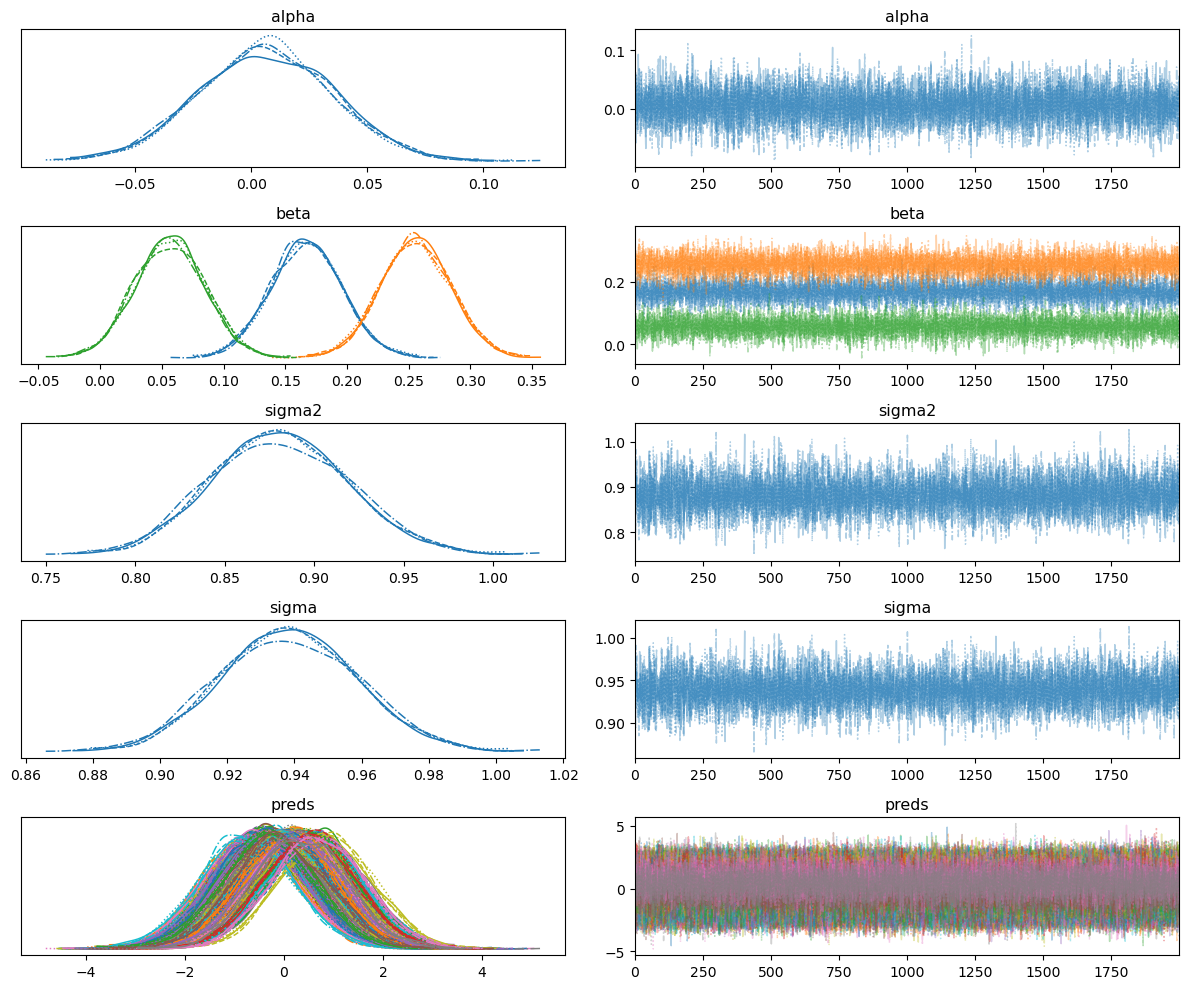

In [20]:
# Traceplots and marginals - visual convergence checks
axarr = az.plot_trace(fit_vectorized)
plt.tight_layout()

In [21]:
# Calculate RMSE 
preds = fit_vectorized.__getitem__('preds')
preds_mean = preds.mean(axis=1) 
RMSE = np.sqrt(np.mean((preds_mean - y_test)**2))
RMSE

0.9457446521917717

In [38]:
data['charges'].min()

-1.0031822537315649

In [39]:
data['charges'].max()

4.170103954308562

In [37]:
data_range = data['charges'].max() - data['charges'].min()
RMSE/data_range

0.1828131315684663

#### How good are your predictions? 
The RMSE value provides the deviation between predicted and actual values. Our RMSE value is 0.946 and the standardized charges have values ranging from about -1 to about 4.17. Thus, our RMSE is about 18.3% of the data range. This means our predictions are somewhat accurate but not perfect.

#### What information did you lose by computing the predictive means? 
By computing predictive means we collapse our dataset into one value. This means we lose information about uncertainty. By the look of our graphs, there is quite a bit of uncertainty in predictive values. By losing this information, our prediction did a poor job of representing the underlying data generating process

#### How could you possibly propagate the uncertainty information encoded in the predictive distribution to obtain a distribution over the test RMSE values?
We would want to use a method that take mulitple samples of the predictive distribution and compute the RMSE value for each individual sample. This would give us a distribution of RMSE value that allow us to understand the uncertainty in our original distributions.
